In [1]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [2]:
! kaggle datasets download -d ashishpatel26/facial-expression-recognitionferchallenge

facial-expression-recognitionferchallenge.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
import zipfile
local_zip = "facial-expression-recognitionferchallenge.zip"
zip_ref = zipfile.ZipFile(local_zip, "r")
zip_ref.extractall("./database")
zip_ref.close()

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.layers import (Activation, BatchNormalization, Conv2D,
                                     Dense, Dropout, Flatten, LeakyReLU,
                                     MaxPooling2D)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.utils import np_utils

In [5]:
# Load the dataframe dataset
dataframe_path = "./data/fer2013/fer2013/fer2013.csv"
df = pd.read_csv(dataframe_path)

In [6]:
# Preprocessing
labels = {0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy", 4: "Sad", 5: "Surprise", 6: "Neutral"}

In [7]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [8]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = np_utils.to_categorical(img_labels)

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(
    img_array,
    img_labels,
    shuffle=True,
    stratify=img_labels,
    test_size=0.2,
    random_state=42
)

print(len(y_train),len(y_valid),len(X_train),len(X_valid))

28709 7178 28709 7178


In [10]:
X_train = np.array(X_train) / 255.0
X_valid = np.array(X_valid) / 255.0
y_train = np.array(y_train)
y_valid = np.array(y_valid)

In [11]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = np_utils.to_categorical(img_labels)
print(len(y_train),len(y_valid),len(X_train),len(X_valid))

28709 7178 28709 7178


In [12]:
# Parameters
num_classes = 7
input_shape = (48, 48, 1)

In [13]:
model = Sequential()

model.add(Conv2D(filters=64,kernel_size=(5,5),input_shape=(input_shape),activation='elu',padding='same',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64,kernel_size=(5,5),activation='elu',padding='same',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(filters=128,kernel_size=(3,3),activation='elu',padding='same',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128,kernel_size=(3,3),activation='elu',padding='same',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(filters=256,kernel_size=(3,3),activation='elu',padding='same',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Conv2D(filters=256,kernel_size=(3,3),activation='elu',padding='same',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(128,activation='elu',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.6))

model.add(Dense(num_classes,activation='softmax'))

opt = optimizers.Adam(0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        1664      
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                        

In [14]:
class ConvolutionCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') >= 0.93:
            print("Reached greater than 93.0% accuracy, so canceling training!")
            self.model.stop_training = True

convolutionCallback = ConvolutionCallback()


In [15]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
    convolutionCallback
]


In [16]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)

train_datagen.fit(X_train)

In [17]:
history = model.fit(
    X_train.reshape(-1, 48, 48, 1),
    y_train,
    batch_size=32,
    steps_per_epoch=len(X_train) // 32,
    epochs=100,
    validation_data=(X_valid.reshape(-1, 48, 48, 1), y_valid),
    callbacks=callbacks,
    use_multiprocessing=True
)


Epoch 1/100
897/897 [==============================] - 37s 31ms/step - loss: 1.8758 - accuracy: 0.3340 - val_loss: 1.4369 - val_accuracy: 0.4422 - lr: 0.0010
Epoch 2/100
897/897 [==============================] - 28s 30ms/step - loss: 1.4141 - accuracy: 0.4586 - val_loss: 1.2629 - val_accuracy: 0.5118 - lr: 0.0010
Epoch 3/100
897/897 [==============================] - 28s 32ms/step - loss: 1.3105 - accuracy: 0.5004 - val_loss: 1.2046 - val_accuracy: 0.5376 - lr: 0.0010
Epoch 4/100
897/897 [==============================] - 27s 30ms/step - loss: 1.2365 - accuracy: 0.5344 - val_loss: 1.1919 - val_accuracy: 0.5499 - lr: 0.0010
Epoch 5/100
897/897 [==============================] - 28s 32ms/step - loss: 1.1856 - accuracy: 0.5558 - val_loss: 1.1804 - val_accuracy: 0.5515 - lr: 0.0010
Epoch 6/100
897/897 [==============================] - 27s 30ms/step - loss: 1.1434 - accuracy: 0.5735 - val_loss: 1.0758 - val_accuracy: 0.5894 - lr: 0.0010
Epoch 7/100
897/897 [==============================]

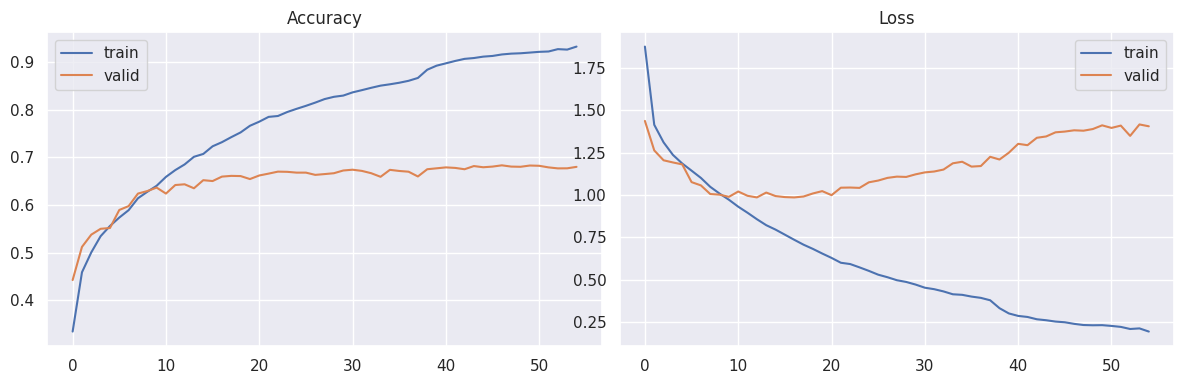

In [22]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
plt.title('Loss')
plt.show()

1/1 [==============================] - 0s 23ms/step


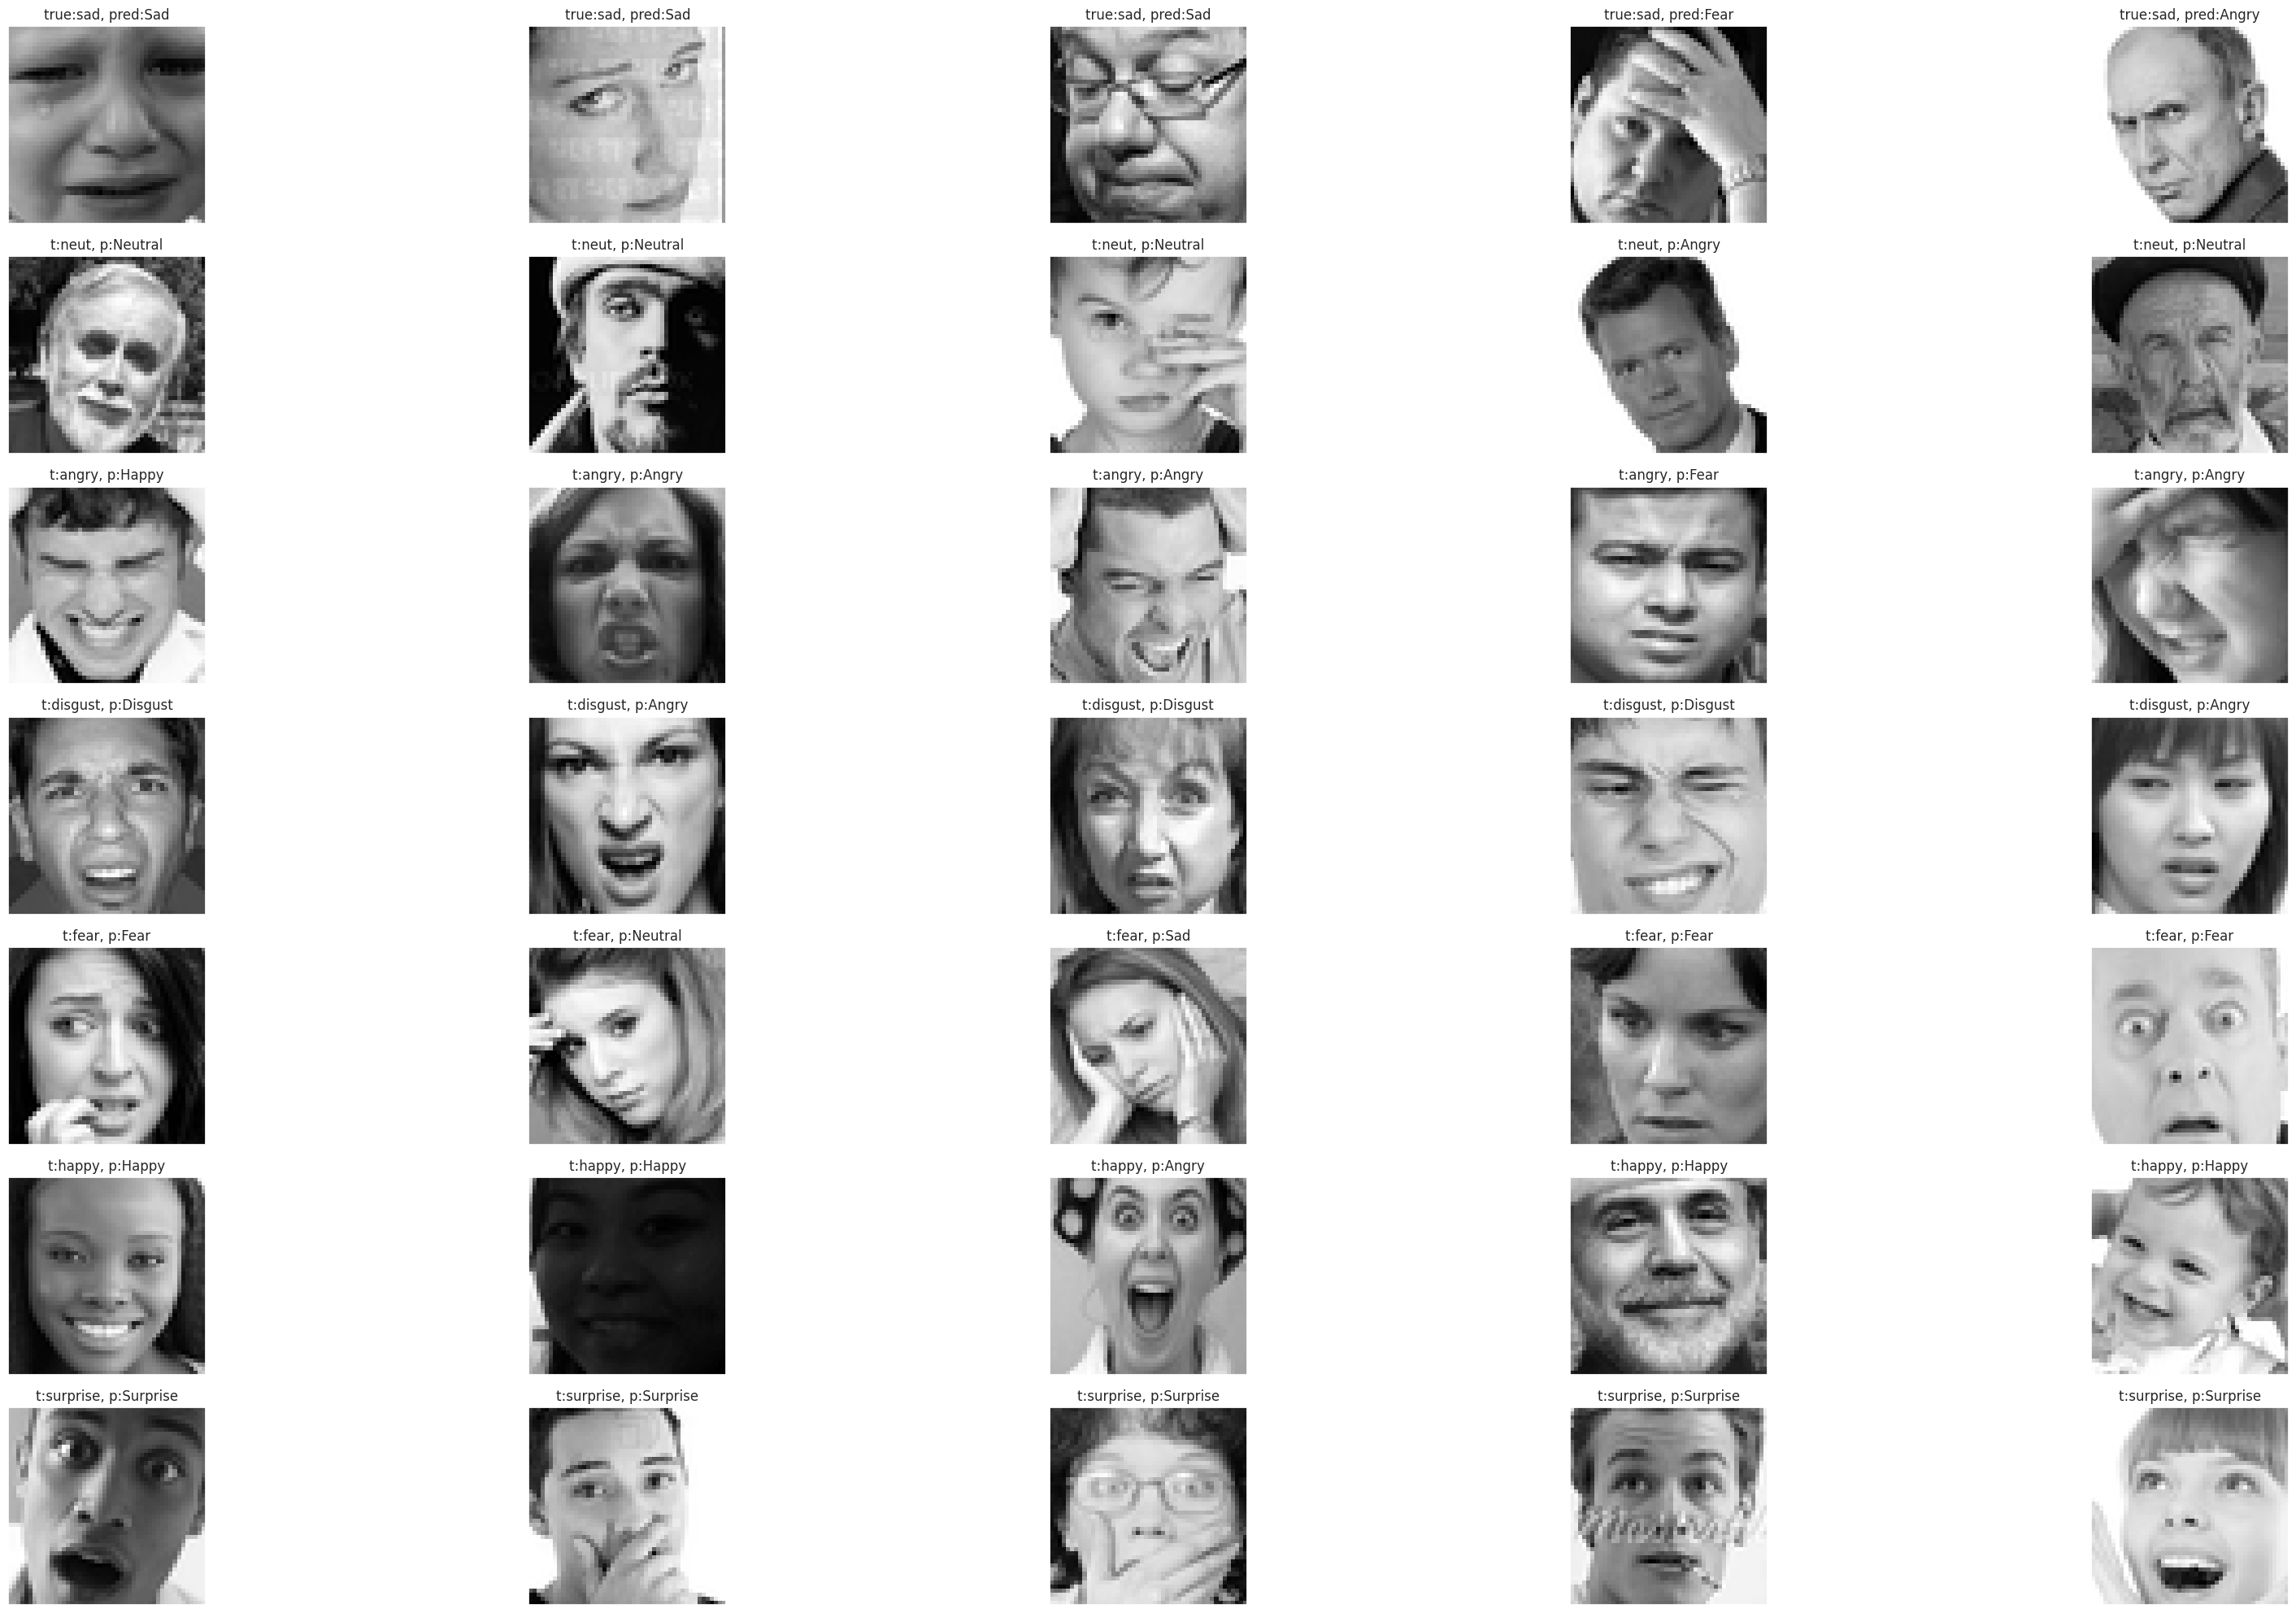

In [34]:
mapper = {0: "Angry",
          1: "Disgust",
          2: "Fear",
          3: "Happy",
          4: "Sad",
          5: "Surprise",
          6: "Neutral"
        }
np.random.seed(2)

random_angry_imgs = np.random.choice(np.where(y_valid[:, 0]==1)[0], size=5)
random_disgust_imgs = np.random.choice(np.where(y_valid[:, 1]==1)[0], size=5)
random_fear_imgs = np.random.choice(np.where(y_valid[:, 2]==1)[0], size=5)
random_happy_imgs = np.random.choice(np.where(y_valid[:, 3]==1)[0], size=5)
random_sad_imgs = np.random.choice(np.where(y_valid[:, 4]==1)[0], size=5)
random_surprise_imgs = np.random.choice(np.where(y_valid[:, 5]==1)[0], size=5)
random_neutral_imgs = np.random.choice(np.where(y_valid[:, 6]==1)[0], size=5)

fig = plt.figure(1, (35, 20))

for i, (sadidx, neuidx, angidx, digidx, fearidx, happyidx, suridx) in enumerate(zip(random_sad_imgs, random_neutral_imgs, random_angry_imgs, random_disgust_imgs, random_fear_imgs, random_happy_imgs, random_surprise_imgs)):
    ax = plt.subplot(7, 5, i+1)
    sample_img = X_valid[sadidx, :, :, 0]
    ax.imshow(sample_img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"true:sad, pred:{mapper[model.predict(sample_img.reshape(1, 48, 48, 1)).argmax()]}")

    ax = plt.subplot(7, 5, i+6)
    sample_img = X_valid[neuidx, :, :, 0]
    ax.imshow(sample_img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"t:neut, p:{mapper[model.predict(sample_img.reshape(1, 48, 48, 1)).argmax()]}")

    ax = plt.subplot(7, 5, i+11)
    sample_img = X_valid[angidx, :, :, 0]
    ax.imshow(sample_img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"t:angry, p:{mapper[model.predict(sample_img.reshape(1, 48, 48, 1)).argmax()]}")

    ax = plt.subplot(7, 5, i+16)
    sample_img = X_valid[digidx, :, :, 0]
    ax.imshow(sample_img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"t:disgust, p:{mapper[model.predict(sample_img.reshape(1, 48, 48, 1)).argmax()]}")

    ax = plt.subplot(7, 5, i+21)
    sample_img = X_valid[fearidx, :, :, 0]
    ax.imshow(sample_img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"t:fear, p:{mapper[model.predict(sample_img.reshape(1, 48, 48, 1)).argmax()]}")

    ax = plt.subplot(7, 5, i+26)
    sample_img = X_valid[happyidx, :, :, 0]
    ax.imshow(sample_img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"t:happy, p:{mapper[model.predict(sample_img.reshape(1, 48, 48, 1)).argmax()]}")

    ax = plt.subplot(7, 5, i+31)
    sample_img = X_valid[suridx, :, :, 0]
    ax.imshow(sample_img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"t:surprise, p:{mapper[model.predict(sample_img.reshape(1, 48, 48, 1)).argmax()]}")

plt.tight_layout()



In [35]:

# Save the model
model.save("facial_emotions_model.h5")